## NLP

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

**Считываем ранее сохранённые данные.**

In [2]:
data = pd.read_csv('sports.csv')
data.head(10)

,Unnamed: 0,content,comments
0,0,30-й тур Ла Лиги открылся матчем между «Уэской...,1286
1,1,Полузащитник Джесси Лингард показывает результ...,72
2,2,В 25-м туре РПЛ «Зенит» играет на выезде с «Со...,74
3,3,Главный тренер «Краснодара» Виктор Гончаренко ...,42
4,4,В 25-м туре РПЛ «Ростов» проиграл «Рубину» (0:...,1664
5,5,31-й тур АПЛ открылся матчем между «Фулхэмом» ...,1171
6,6,В 30-м туре Серии А «Милан» победил «Парму» (3...,155
7,7,В 25-м туре РПЛ «Краснодар» потерпел поражение...,196
8,8,Стал известен характер травмы хавбека «Реала» ...,79
9,9,В 30-м туре Серии А «Интер» победил «Кальяри» ...,44


**Пример новости.**

In [3]:
data['content'][38]

'В 30-м туре Ла Лиги «Реал»\xa0обыграл\xa0«Барселону»\xa0(2:1).\nSports.ru провел\xa0текстовую онлайн-трансляцию этого матча.\nВ турнирной таблице «Мадрид» обошел каталонцев и опережает теперь на одно очко.\nКоманда Зинедина Зидана догнала по очкам лидера Ла Лиги «Атлетико» (по 66), у которого имеется игра в запасе. В 30-м туре «Атлетико» 11 апреля встретится с «Бетисом».\n«Барселона» с 65 очками занимает третью позицию.\n\n\n\n\nРеал Мадрид – Барселона\n\n\n2:1\xa0(2:0, 0:1)\n\n\n\nДата проведения\n\n10 апреля, 22.00,\xa0«Эстадио Альфредо Ди Стефано» \n\n\nпревью матча\nтекстовый онлайн\nстатистика\n\n \n\nГолы: \n\n\n1:0 –\n13\xa0Бензема, \n\n2:0 –\n28\xa0Кроос, \n\n2:1 –\n60\xa0Мингеса.\n\n\n\nРеал Мадрид –\nКуртуа, Менди, Милитао, Начо, Васкес (Одриосола, 43), Модрич, Кроос (Иско, 72), Вальверде (Асенсио, 61), Каземиро, Винисиус Жуниор (Марсело, 72), Бензема (Мариано Диас, 72).\t\t\t\n\n\nБарселона –\t\t\t\nтер Стеген, Дест (Гризманн, 46), Мингеса, Араухо (Мориба, 72), Альба, Дембе

**Удалим лишний столбец.**

In [4]:
data.rename(columns={'Unnamed: 0':'id'}, inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014 entries, 0 to 2013
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2014 non-null   int64 
 1   content   2014 non-null   object
 2   comments  2014 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 47.3+ KB


**Проведём небольшую очистку.** Избавимся от дубликатов, а также от специфических новостей с большим числом комментов. Это «долгоиграющие» новости — например, идёт очередной тур в лиге, и новость обновляется в течение нескольких дней по мере прохождения матчей. Такие новости собирают гораздо больше комментов, чем рядовые, но ценности не несут.

In [6]:
data = data[(data['id'] > 5) | (data['comments'] < 1000)]
data.drop_duplicates(subset='content', inplace=True)
data.reset_index(drop=True, inplace=True)
data

,id,content,comments
0,1,Полузащитник Джесси Лингард показывает результ...,72
1,2,В 25-м туре РПЛ «Зенит» играет на выезде с «Со...,74
2,3,Главный тренер «Краснодара» Виктор Гончаренко ...,42
3,6,В 30-м туре Серии А «Милан» победил «Парму» (3...,155
4,7,В 25-м туре РПЛ «Краснодар» потерпел поражение...,196
...,...,...,...
1945,2006,Центральный защитник «Вильярреала» Пау Торрес ...,35
1946,2007,Форвард «Аталанты» Луис Муриэль забил победный...,35
1947,2008,Бывший нападающий «Сочи» и «Тамбова» Александр...,290
1948,2009,«Боруссия» Менхенгладбах уступила «Аугсбургу» ...,70


**Сохраним столбцы для будущего использования.**

In [7]:
content = data['content']
comments = data['comments']

**Подключаем библиотеки.**

In [8]:
from natasha import MorphVocab, Doc, Segmenter, NewsEmbedding, NewsMorphTagger
morph_vocab = MorphVocab()
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

In [9]:
from nltk.corpus import stopwords

**Функция для лемматиации с использованием библиотеки natasha.** Здесь же очищаем от символов пунктуации, убираем числа (в спортивных новостях это, как правило, обозначение голов, минут), убираем стоп-слова.

In [10]:
def lemmatize(doc):
#     lemmas = mystem.lemmatize(doc)
#     return ''.join(lemmas)
    lemmas = []
    doc1 = Doc(doc)
    doc1.segment(segmenter)
    doc1.tag_morph(morph_tagger)
    for token in doc1.tokens:
        if token.text in '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~«»—–':
            continue
        if token.text.isdigit():
            continue
        if token.text in stopwords.words('russian'):
            continue
        token.lemmatize(morph_vocab)
        lemmas.append(token.lemma)
    return ' '.join(lemmas)

In [11]:
content = content.apply(lemmatize)

In [12]:
content.to_csv('sports_lemmatized.csv')

**Создадим новый датафрейм из лемматизированных документов и числа комментов.**

Для обучения модели у нас получилось 1950 текстов.

In [13]:
data1 = pd.DataFrame({'content': content, 'comments': comments})
data1

,content,comments
0,полузащитник джесси лингард показывать результ...,72
1,в 25-м тур рпл зенит играть выезд сочи sports ...,74
2,главный тренер краснодар виктор гончаренко про...,42
3,в 30-й тур серия а милан победить парма в воск...,155
4,в 25-м тур рпл краснодар потерпеть поражение а...,196
...,...,...
1945,центральный защитник вильярреал пау торрес око...,35
1946,форвард аталант луис муриэль забить победный г...,35
1947,бывший нападающий сочи тамбов александр карапе...,290
1948,боруссия менхенгладб уступить аугсбург 25-м ту...,70


**Train-test split.**

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data1.drop(['comments'], axis=1), data1['comments'], test_size=0.25, random_state=100
)

**TF-IDF векторизация.** Используем отдельные слова и биграммы. Параметры max_df и min_df подобраны экспериментально для обеспечения наилучших показателей качества.

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(norm=None, ngram_range=(1,2), max_df=0.99, min_df=0.001)

In [57]:
X_train_vect = pd.DataFrame(
    vectorizer.fit_transform(X_train['content']).todense(), 
    columns=vectorizer.get_feature_names()
)

In [58]:
X_train_vect.shape

(1462, 26055)

После векторизации на тренировочном датасете получилось 26055 признаков. Для тестового датасета используем те же признаки.

In [59]:
X_test_vect = pd.DataFrame(
    vectorizer.transform(X_test['content']).todense(), 
    columns=vectorizer.get_feature_names()
)

In [60]:
X_test_vect.shape

(488, 26055)

**Создадим заготовку для сравнения метрик по разным моделям.**

In [61]:
from sklearn import metrics

def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred)
    ]
    return stats

measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
RMSE
R2


**Baseline: медианное число комментов.**

In [62]:
median_train = y_train.median()
y_test_baseline = np.array([median_train]*len(y_test))

In [63]:
measured_metrics["baseline"] = dataframe_metrics(y_test, y_test_baseline)
measured_metrics

,error_type,baseline
0,MAE,68.637295
1,RMSE,127.353484
2,R2,-0.106683


### Линейная регрессия

In [64]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

In [65]:
lin_reg = LinearRegression()

lin_reg.fit(X_train_vect, y_train)

LinearRegression()

In [66]:
measured_metrics["lin_reg"] = dataframe_metrics(y_test, lin_reg.predict(X_test_vect))
measured_metrics

,error_type,baseline,lin_reg
0,MAE,68.637295,73.624338
1,RMSE,127.353484,113.573407
2,R2,-0.106683,0.119853


MAE чуть хуже, чем в baseline, RMSE и R2 чуть лучше.

Посмотрим на важность признаков.

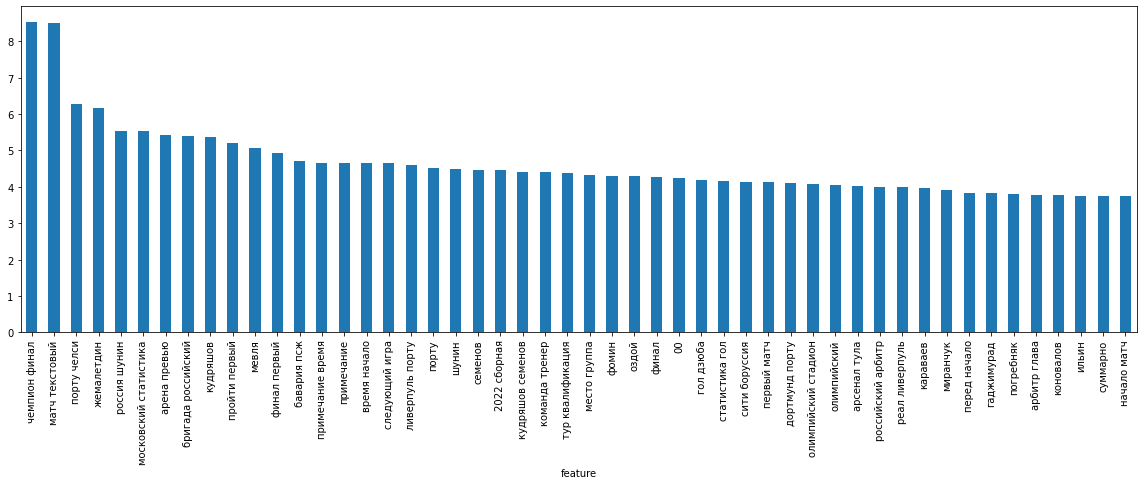

In [67]:
featureImportance = pd.DataFrame({'feature': X_train_vect.columns, 
                                  'importance': lin_reg.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(['importance'], ascending=False, inplace=True)
featureImportance['importance'][:50].plot.bar(figsize=(20, 6));

На вершине *чемпион финал* — скорее всего, это биграмма от «Лига чемпионов. Финал».

*матч текстовый* — наверное, из новостей, в которых объявляется о каком-то матче и текстовой трансляции. Близко к этому биграмма *арена превью*.

В топе видны биграммы конкретных матчей с высоким интересом: *порту челси*, *бавария псж*, *ливерпуль порту*, *сити боруссия*.

В топе много фамилий российских футболистов-сборников: *жемалетдин*, *кудряшов*, *мевля*, *россия шунин*, *семенов*.

Также в топе биграммы из новостей, сообщающих результаты или превью матчей: *пройти первый*, *примечание время*, *время начало*, *следующий игра*.

### RidgeCV

In [68]:
ridge_cv = RidgeCV()

ridge_cv.fit(X_train_vect, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [69]:
measured_metrics["ridge_cv"] = dataframe_metrics(y_test, ridge_cv.predict(X_test_vect))
measured_metrics

,error_type,baseline,lin_reg,ridge_cv
0,MAE,68.637295,73.624338,73.509228
1,RMSE,127.353484,113.573407,113.439553
2,R2,-0.106683,0.119853,0.121927


По метрикам совсем незначительно улучшение по сравнению с обычной линейной регрессией.

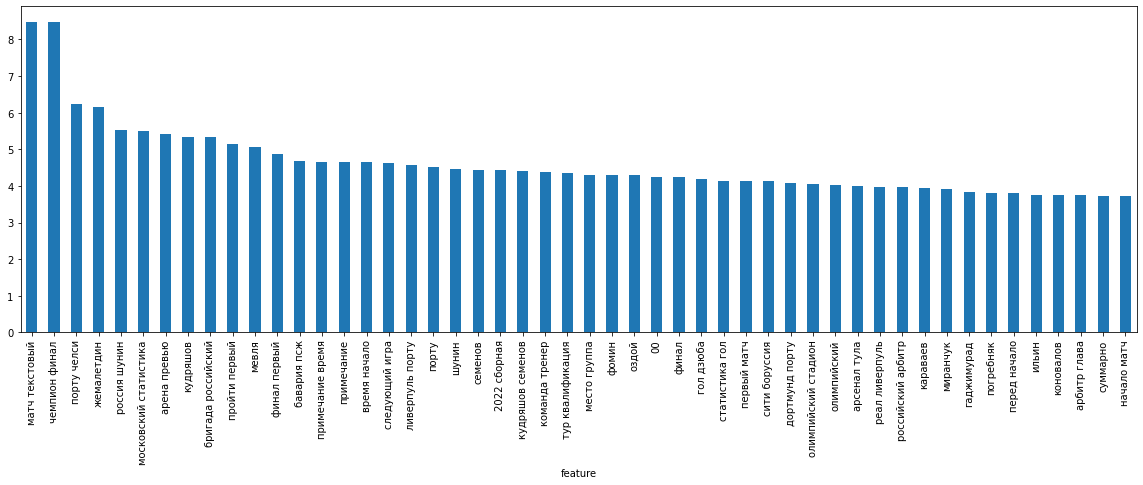

In [71]:
featureImportance = pd.DataFrame({'feature': X_train_vect.columns, 
                                  'importance': ridge_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(['importance'], ascending=False, inplace=True)
featureImportance['importance'][:50].plot.bar(figsize=(20, 6));

По важности признаков картина аналогична линейной регрессии.

### LassoCV

In [70]:
lasso_cv = LassoCV()

lasso_cv.fit(X_train_vect, y_train)

C:\Users\andsi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13880.570455162553, tolerance: 6208.115024465355
  model = cd_fast.enet_coordinate_descent(
C:\Users\andsi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26846.05337070569, tolerance: 6208.115024465355
  model = cd_fast.enet_coordinate_descent(
C:\Users\andsi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26394.99756036885, tolerance: 6208.115024465355
  model = cd_fast.enet_coordinate_descent(
C:\Users\andsi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

LassoCV()

In [72]:
measured_metrics["lasso_cv"] = dataframe_metrics(y_test, lasso_cv.predict(X_test_vect))
measured_metrics

,error_type,baseline,lin_reg,ridge_cv,lasso_cv
0,MAE,68.637295,73.624338,73.509228,70.511135
1,RMSE,127.353484,113.573407,113.439553,116.972355
2,R2,-0.106683,0.119853,0.121927,0.066384


По MAE небольшое улучшение в сравнении с обычной линейной регрессией, но по-прежнему хуже baseline. По RMSE и R2 хуже, чем обычная линейная регрессия.

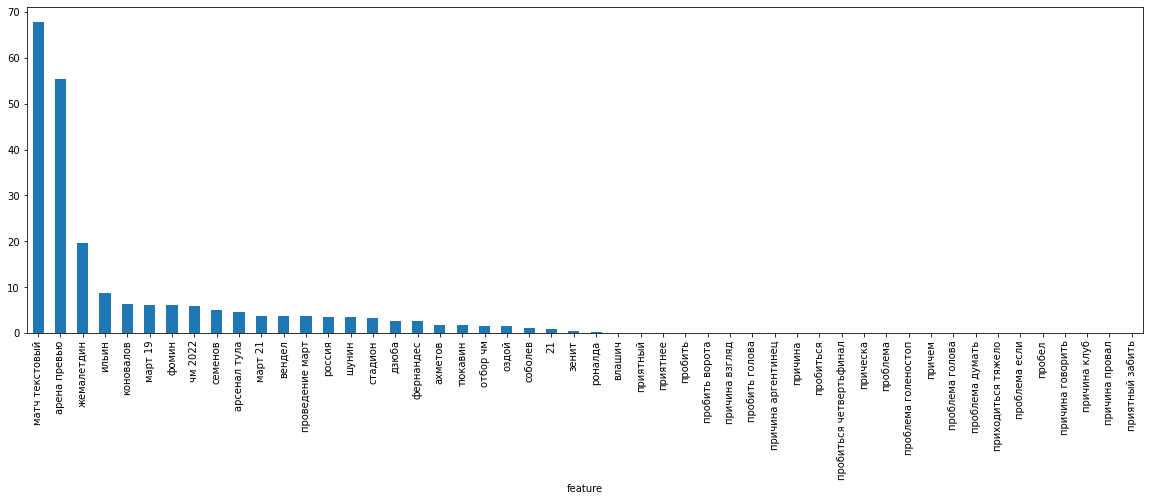

In [73]:
featureImportance = pd.DataFrame({'feature': X_train_vect.columns, 
                                  'importance': lasso_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(['importance'], ascending=False, inplace=True)
featureImportance['importance'][:50].plot.bar(figsize=(20, 6));

В лассо-регрессии выделяется только небольшое количество важных признаков. В самом топе *матч текстовый* и *арена превью*. Из остальных признаков, которые обладают хотя бы небольшой важностью, большинство являются фамилиями конкретных футболистов.

### ElasticNetCV

In [74]:
elastic_net = ElasticNetCV()

elastic_net.fit(X_train_vect, y_train)

C:\Users\andsi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95716.47912359331, tolerance: 11441.31264404925
  model = cd_fast.enet_coordinate_descent(


ElasticNetCV()

In [75]:
measured_metrics["elastic_net"] = dataframe_metrics(y_test, elastic_net.predict(X_test_vect))
measured_metrics

,error_type,baseline,lin_reg,ridge_cv,lasso_cv,elastic_net
0,MAE,68.637295,73.624338,73.509228,70.511135,65.956784
1,RMSE,127.353484,113.573407,113.439553,116.972355,100.704393
2,R2,-0.106683,0.119853,0.121927,0.066384,0.308012


В этой модели все метрики качества значительно улучшились.

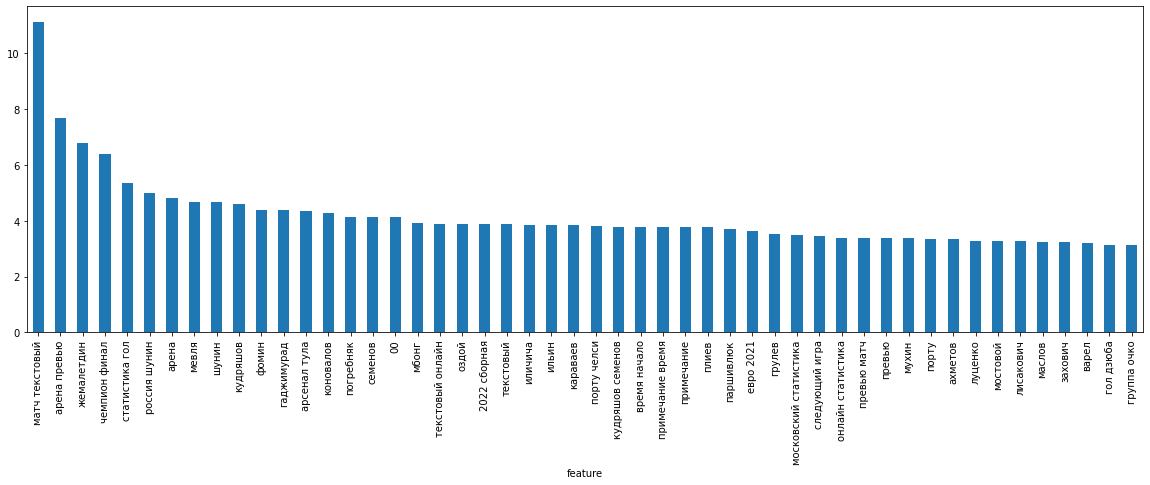

In [76]:
featureImportance = pd.DataFrame({'feature': X_train_vect.columns, 
                                  'importance': elastic_net.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(['importance'], ascending=False, inplace=True)
featureImportance['importance'][:50].plot.bar(figsize=(20, 6));

По важности признаков картина перекликается с обычной линейной регрессией.

### Выводы

Для выбранной тематики спарсили новости и построили несколько моделей регрессии, попытавшись выявить зависимость между наличием определённых слов и биграмм и количеством комментов пользователей.

Лучше всего себя показал алгоритм ElasticNet, хотя в текущей версии метрики качества недостаточно хороши. Возможно, они бы повысились при существенном увеличении базы текстов.